In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

# Double pendulum simulation

In [3]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg')

Equation 11.37

$U(\phi_1,\phi_2 ) = (m_1 + m_2)g L_1 (1-cos(\phi_1))+m_2 g L_2(1-cos(\phi_2)) $

Equation 11.38

$T = \frac{1}{2} (m_1 + m_2)L_1^2 \dot{\phi_1^2} + m_2 L_1 L_2 \dot{\phi_1}\dot{\phi_2} cos(\phi_1-\phi_2) + \frac{1}{2}m_2 L_2^2 \dot{\phi_2^2}  $

$\mathcal{L} = T - U$

$\ddot{\phi_1} = \frac{m_2 g sin(\phi_2)cos(\phi_1-\phi_2)
-m_2 sin(\phi_1-\phi_2)(L_1 \dot{\phi_1^2} cos(\phi_1-\phi_2) + L_2 \dot{\phi_2^2}
-(m_1+m_2)g sin(\phi_1)}
{L_1(m_1+m_2 sin^2(\phi_1-\phi_2))} $


$\ddot{\phi_2} = \frac{(m_1+m_2)(L_1 \dot{\phi_1^2}sin(\phi_1-\phi_2) - g sin(\phi_2)+g sin(\phi_1)cos(\phi_1-\phi_2))
+ m_2 L_2 \dot{\phi_2^2}sin(\phi_1-\phi_2)cos(\phi_1-\phi_2)}{L_2(m_1 + m_2 sin^2(\phi_1-\phi_2))}$



### Class and setup

In [4]:
class LagrangianPendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the 1st pendulum
    L2 : float
        length of the 2nd pendulum
    g : float
        gravitational acceleration at the earth's surface
    mass : float
        mass of pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., mass1=1., mass2=1., g=1.):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = mass1
        self.m2 = mass2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi1(t), y[1] = dphi1/dt,
                                      y[2] = phi2(t), y[3] = dphi2/dt
            
        Returns
        -------
        
        """
        cos = np.cos(y[0]-y[2])
        sin = np.sin(y[0]-y[2])
        dd1 = (self.m2*self.g*np.sin(y[0])*cos - \
                self.m2*sin*(self.L1*y[1]**2)- \
                (self.m1+self.m2)*self.g*np.sin(y[0]))\
               / self.L1 / (self.m1+self.m2*sin**2)
               
        dd2 = ((self.m1+self.m2)*(self.L1*y[1]**2*sin - \
                self.g*np.sin(y[2]) + self.g*np.sin(y[0])*cos) + \
                self.m2*self.L2*y[3]**2*sin*cos) \
               / self.L2 / (self.m1 + self.m2*sin**2)
        return [y[1], dd1,\
                y[3], dd2]
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0,
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

### Making the plot

In [7]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate a pendulum 
p1 = LagrangianPendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)

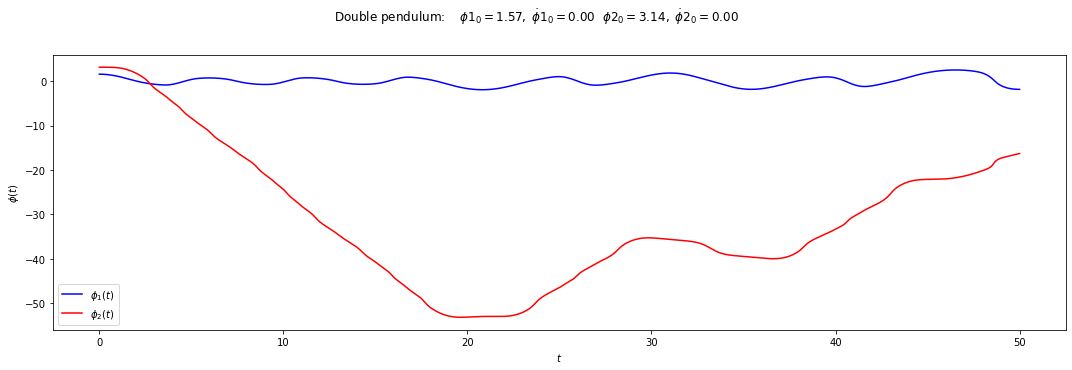

In [8]:
phi1_0 = (1./2.)*np.pi
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.


phi1, phi1_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0,
                                             phi2_0, phi2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum:  ' + \
                rf'  $\phi1_0 = {phi1_0:.2f},$' + \
                rf' $\dot\phi1_0 = {phi1_dot_0:.2f}$' + \
                rf'  $\phi2_0 = {phi2_0:.2f},$' + \
                rf' $\dot\phi2_0 = {phi2_dot_0:.2f}$' 
                #'\n'      \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
     
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r'$\phi_1(t)$', 
            ax=ax_a)    

plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            color='red',
            label=r'$\phi_2(t)$',  
            ax=ax_a) 
fig.tight_layout()
fig.savefig('double_pendulum.png' , bbox_inches='tight')

### Showing it is a chaotic system

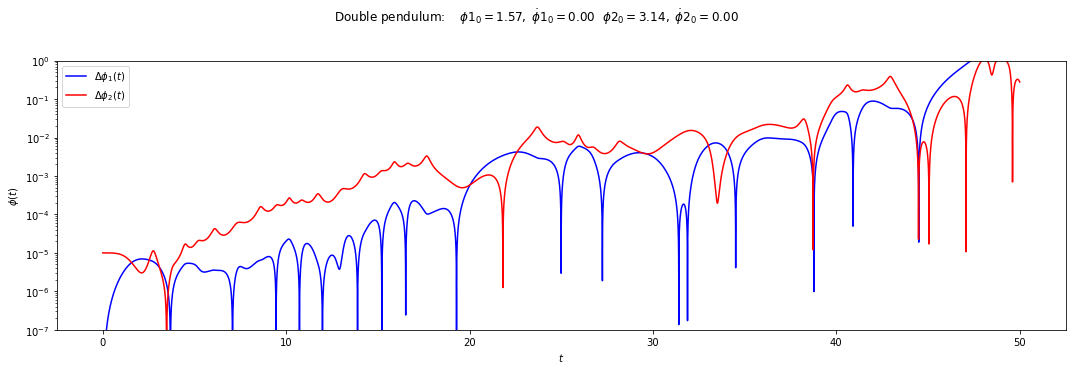

In [9]:
phi1_0 = (1./2.)*np.pi
phi1_dot_0 = 0.
phi2_0 = 1.*np.pi
phi2_dot_0 = 0.


phi1, phi1_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0,
                                             phi2_0, phi2_dot_0)

phi1b, phi1b_dot, phi2b, phi2b_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0,
                                             phi2_0-0.00001, phi2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum:  ' + \
                rf'  $\phi1_0 = {phi1_0:.2f},$' + \
                rf' $\dot\phi1_0 = {phi1_dot_0:.2f}$' + \
                rf'  $\phi2_0 = {phi2_0:.2f},$' + \
                rf' $\dot\phi2_0 = {phi2_dot_0:.2f}$' 
                #'\n'      \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(phi1[start : stop]-phi1b[start : stop]), 
            axis_labels=phi_vs_time_labels, 
            color='blue', semilogy=True,
            label=r'$\Delta\phi_1(t)$', 
            title=None, 
            ax=ax_a)    

plot_y_vs_x(t_pts[start : stop], np.abs(phi2[start : stop]-phi2b[start : stop]),
            axis_labels=phi_vs_time_labels, 
            color='red', semilogy=True,
            label=r'$\Delta\phi_2(t)$', 
            title=None, 
            ax=ax_a) 

ax_a.set_ylim(1.e-7,1.)

fig.tight_layout()
fig.savefig('double_pendulum_diffrence.png' , bbox_inches='tight')

This shows it is a chaotic system. If the system was non-chaotic the small change in initial conditions would remain constant throughout. A pendulum with one mass that was started from two very similar conditions will not have much difference in mass position as time changes. This is because it is non-chaotic. We can see and inconsistent difference between mass 1 and mass 2 this shows hyper sensitivity to the initial conditions which is a chaotic condition.  